## Ensemble-based OOD detection

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn

import sys
sys.path.append("../src/models")
from NN import SimpleBinaryClassificationNet

sys.path.append("../src/OODmetrics/")
from ensemble import epistemic_uncertainty
from ensemble import make_pred_proba_array

from sklearn.metrics import roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
# load
X_test = torch.Tensor(np.load("../data/external/X_test.npy"))
y_test = torch.Tensor(np.load("../data/external/y_test.npy"))

path_1 = "../src/models/weight/Simple_NN_Ensembles.pkl"
path_2 = "../src/models/weight/Adversarial_NN_Ensembles.pkl"

f_1 = open(path_1,"rb")
f_2 = open(path_2,"rb")

Simple_NN_Ensembles = pickle.load(f_1)
Adversarial_NN_Ensembles = pickle.load(f_2)

In [4]:
Adversarial_NN_Ensembles[0]

SimpleBinaryClassificationNet(
  (layers1): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
  )
  (layers2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layers_out): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
Simple_NN_Ensembles_pred_list = []
Simple_NN_Ensembles_pos_neg_pred_list = []
for _, Net in enumerate(Simple_NN_Ensembles):
    Net.eval()
    with torch.no_grad():
        _pred_list = torch.sigmoid(Net(X_test).squeeze()).tolist()
        pos_neg_pred_array = make_pred_proba_array(_pred_list)
        print(roc_auc_score(y_test, _pred_list,labels=1))
        
        Simple_NN_Ensembles_pred_list.append(_pred_list)
        Simple_NN_Ensembles_pos_neg_pred_list.append(pos_neg_pred_array)

0.8930152979066023
0.8920088566827697
0.8910024154589372
0.8881843800322061
0.89170692431562


In [8]:
# make grid
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_test[:, 0].detach().numpy().min()-1, X_test[:, 0].detach().numpy().max()+1),
    np.linspace(X_test[:, 1].detach().numpy().min()-1, X_test[:, 1].detach().numpy().max()+1)
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

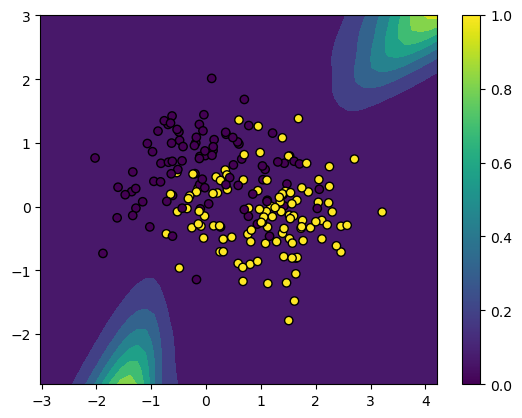

In [12]:
# Simple NN Ensemble epistemic uncertainty
grid_Simple_NN_Ensembles_pred_list = []
grid_Simple_NN_Ensembles_pos_neg_pred_list = []
for _, Net in enumerate(Simple_NN_Ensembles):
    Net.eval()
    with torch.no_grad():
        _pred_list = torch.sigmoid(Net(torch.tensor(grid).float()).squeeze()).tolist()
        _pos_neg_pred_array = make_pred_proba_array(_pred_list) # add
        
        grid_Simple_NN_Ensembles_pred_list.append(_pred_list)
        grid_Simple_NN_Ensembles_pos_neg_pred_list.append(_pos_neg_pred_array)
        
grid_Simple_NN_Ensembles_pred_ = np.array(grid_Simple_NN_Ensembles_pos_neg_pred_list)

grid_Simple_NN_Ensembles_epistemic = epistemic_uncertainty(grid_Simple_NN_Ensembles_pred_,2)

display = DecisionBoundaryDisplay(
    xx0=feature_1,xx1=feature_2,response=np.reshape(grid_Simple_NN_Ensembles_epistemic,feature_1.shape)
)
display.plot()
display.ax_.scatter(X_test[:, 0].detach().numpy(), X_test[:, 1].detach().numpy(),c=y_test,edgecolors="black")
plt.colorbar(display.ax_.collections[1])

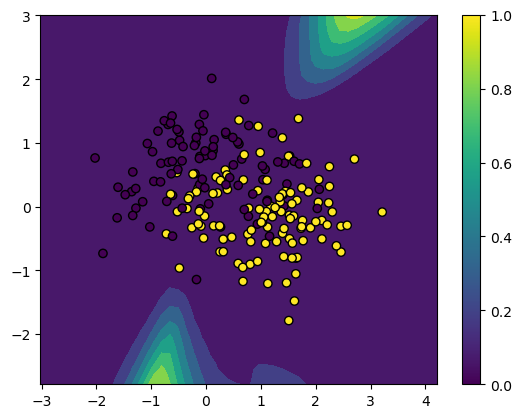

In [15]:
grid_Adversarial_Simple_NN_Ensembles_pred_list = []
for _, Net in enumerate(Adversarial_NN_Ensembles):
    Net.eval()
    with torch.no_grad():
        _pred_list = torch.sigmoid(Net(torch.tensor(grid).float()).squeeze()).tolist()
        _pred_pos_neg_array = make_pred_proba_array(_pred_list)
        
        grid_Adversarial_Simple_NN_Ensembles_pred_list.append(_pred_pos_neg_array)
        
grid_Adversarial_NN_Ensembles_pred_array = np.array(grid_Adversarial_Simple_NN_Ensembles_pred_list)

grid_Adversarial_NN_Ensembles_epistemic = epistemic_uncertainty(grid_Adversarial_NN_Ensembles_pred_array,2)

display = DecisionBoundaryDisplay(
    xx0=feature_1,xx1=feature_2,response=np.reshape(grid_Adversarial_NN_Ensembles_epistemic,feature_1.shape)
)
display.plot()
display.ax_.scatter(X_test[:, 0].detach().numpy(), X_test[:, 1].detach().numpy(),c=y_test,edgecolors="black")
plt.colorbar(display.ax_.collections[1])